<a href="https://colab.research.google.com/github/pallavmarch/WebScraping_PsychologyToday/blob/main/psychologytoday_webscraping_dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from google.colab import files


!pip install pgeocode
import pgeocode

pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
df=pd.read_csv("/content/therapists_profiles_data_Texas.csv",encoding='latin-1')

In [22]:
df[df['Name'] == 'Kathy Lee Siepker']

,Profile URL,Name,Title,Location,State,ZIP Code,Phone,Individual Sessions ($),Couple Sessions ($),Pay By,Insurance,Top Specialties,Expertise,Types of Therapy,Personal Statement,Verified by Psychology Today,In Practice (years),Membership,Certificate,Attended University,Major/Degree,Graduation Year,Qualifications,Endorsement Count,Endorsed By,Age,Participants,Communities,Religion,I also speak
5743,https://www.psychologytoday.com/us/therapists/...,Kathy Lee Siepker,"Clinical Social Work/Therapist,PhD,LCSW,CDP","Flower Mound, TX 75028(214) 692-2076",TX,75028,(214) 692-2076,$150,$150,"ACH Bank transfer, American Express, Discover,...",Aetna | BlueCross and BlueShield | Carelon Beh...,Anxiety | Depression | Dementia,Career Counseling | Coping Skills | Emotional ...,Coaching | Cognitive Behavioral (CBT) | Cultur...,"I am a licensed clinical social worker, therap...",Yes,4,Not Found,National Council of Certified Dementia Practit...,The Ohio State University (PhD); Wash U (MSW),Social Work,2014,Verified byPsychology TodayLicensed by State o...,1,Jamie English - Clinical Social Work/Therapist...,Adults | Elders (65+),Individuals | Couples | Family,Bisexual Allied | Gay Allied | HIV / AIDS Alli...,Not Found,Korean


In [23]:
print(len(df[df['Location'].isnull()]))
df.dropna(subset=['Location'], inplace=True)
print(len(df[df['Location'].isnull()]))

2
0


## Adding columns

In [24]:
df['Age'] = df['Age'].replace({'Elders (65+)': 'Elders'})
df['Dementia'] = df['Expertise'].str.lower().str.contains('dementia') | df['Top Specialties'].str.lower().str.contains('dementia')
df['Autism'] = df['Expertise'].str.lower().str.contains('autism') | df['Top Specialties'].str.lower().str.contains('autism')
df['Depression'] = df['Expertise'].str.lower().str.contains('depression') | df['Top Specialties'].str.lower().str.contains('depression')
df['Elders (65+)']=df['Age'].str.lower().str.contains('elders')
df['ZIP Code']=df['ZIP Code'].astype(int)

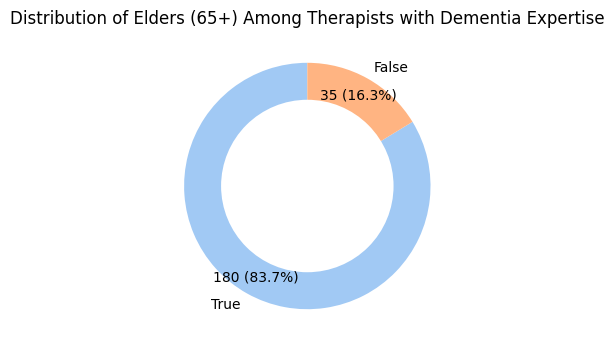

In [25]:
data = df[df['Dementia'] == True]['Elders (65+)'].value_counts()

labels = data.index
sizes = data.values
colors = sns.color_palette("pastel", len(labels))

fig, ax = plt.subplots(figsize=(4, 4))


wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, startangle=90, pctdistance=0.85, colors=colors,
    autopct=lambda p: f'{int(round(p * sum(sizes) / 100))} ({p:.1f}%)',
    textprops={'fontsize': 10}
)


centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax.add_artist(centre_circle)

plt.title('Distribution of Elders (65+) Among Therapists with Dementia Expertise')
plt.show()

## Adding county, city

In [26]:
# Initialize the geocoder for US ZIP codes
nomi = pgeocode.Nominatim('us')

# Function to fetch city and county from ZIP Code
def get_location_info(zip_code):
    location = nomi.query_postal_code(zip_code)
    return pd.Series([location['place_name'], location['county_name']])

df[['City', 'County']] = df['ZIP Code'].astype(str).apply(get_location_info)

# DEMENTIA

In [27]:
Dementia=df[df['Dementia']==True]

Dementia=Dementia[['Name','Title', 'Location', 'City', 'County','ZIP Code', 'State',
       'Individual Sessions ($)', 'Couple Sessions ($)',
       'Insurance', 'Top Specialties', 'Expertise', 'Types of Therapy',
       'In Practice (years)', 'Membership', 'Certificate',
       'Major/Degree', 'Graduation Year', 'I also speak', 'Dementia','Elders (65+)']]


### Insurance

In [28]:
def transform_insurance(row):
  insurance = str(row).lower()
  if "not found" in insurance:
    return "No"
  elif insurance == "out of network":
    return "Out of Network"
  elif "medicare" in insurance and "medicaid" in insurance:
    return "Both Medicare and Medicaid"
  elif "medicare" in insurance:
    return "Medicare"
  elif "medicaid" in insurance:
    return "Medicaid"
  else:
    return "Yes"

Dementia['Insurance_Category'] = Dementia['Insurance'].apply(transform_insurance)


Dementia.insert(10, 'Insurance_Category', Dementia.pop('Insurance_Category'))


### Language

In [42]:
Dementia['I also speak'] = Dementia['I also speak'].str.lower()
Dementia['I also speak'].value_counts()

,count
I also speak,
not found,171
spanish,24
italian | spanish,2
portuguese,1
pidgin-hawaiian,1
hungarian | serbian | spanish,1
mandarin,1
korean,1
italian,1


In [41]:
phrases_to_remove = [
    "se habla espaã±ol | ",
    "conversational ",
    "in spanish and urdu | "
]

pattern = '|'.join(map(re.escape, phrases_to_remove))
Dementia['I also speak'] = Dementia['I also speak'].str.replace(pattern, '', regex=True)
Dementia['I also speak'] = Dementia['I also speak'].str.replace(r'\b(\w+)\s*\|\s*\1\b', r'\1', regex=True)


### Title

In [57]:
Dementia['Title'] = Dementia['Title'].str.lower()
Dementia['Title'].value_counts().sort_index()

,count
Title,
clinical social work/therapist,1
"clinical social work/therapist,dsw,lcsw-s(she, her)",1
"clinical social work/therapist,lcsw",23
"clinical social work/therapist,lcsw(he, him)",1
"clinical social work/therapist,lcsw(she, her)",13
"clinical social work/therapist,lcsw,cart",1
"clinical social work/therapist,lcsw,lcdc",2
"clinical social work/therapist,lcsw,lsw,msw",1
"clinical social work/therapist,lcsw-s",2


In [58]:
Dementia['Title_shorten']=Dementia['Title'].str.split(',').str[0]
Dementia['Title_shorten']=Dementia['Title_shorten'].str.split('(').str[0]
Dementia.insert(2, 'Title_shorten', Dementia.pop('Title_shorten'))
Dementia['Title_shorten'].value_counts()

,count
Title_shorten,
licensed professional counselor,73
clinical social work/therapist,68
psychologist,40
marriage & family therapist,10
licensed professional counselor associate,8
ms,2
marriage & family therapist associate,2
psychological associate,2
lpc associate,2


### Certifications

In [68]:
Dementia['Certificate'] = Dementia['Certificate'].str.lower()
Dementia['Certificate'].value_counts()


,count
Certificate,
not found,143
emdr therapy basic training2020,2
evangelical lutheran church in americaretired clergy / 1990,1
national council of certified dementia practitionerscdp 273459 / 2023,1
american assoc. for marriage and family therapists155259 / 2014,1
national board of certified counselors1629387 / 2021,1
capella universitygeriatric psychology / 2001,1
ccsas2012,1
emdr association / emdr certified55705340 / 2019,1


In [ ]:
Dementia['Certificate_clean']=Dementia['Certificate'].str.split('/').str[0]
Dementia['Certificate_clean'] = Dementia['Certificate_clean'].str.replace(r'[\d,]', '', regex=True)  # Remove numbers and commas


In [70]:
Dementia['Certificate_clean'].value_counts().sort_index()

,count
Certificate_clean,
aamft,1
aamftmft supervisor,1
alternative dispute resolution,1
american assoc. for marriage and family therapists,1
american association of christian counselors,1
american board of clinical social work,1
american counseling association,1
american counseling association,1
american psychotherapy association,1


# CSV file

In [67]:
Dementia.to_csv('Dementia.csv')
files.download('Dementia.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### pivot Table and graph

In [8]:
cols_to_clean = ['Individual Sessions ($)', 'Couple Sessions ($)', 'In Practice (years)']

Dementia[cols_to_clean] = (
    Dementia[cols_to_clean]
    .replace('Not Found', np.nan)
    .apply(lambda x: x.str.replace(r'[$ ]', '', regex=True).astype(float))
   # .astype('Int64')
)


value_counts_list = [
    Dementia[col].value_counts().astype(int).rename_axis(col).reset_index(name='Count')
    for col in cols_to_clean
]
side_by_side = pd.concat(value_counts_list, axis=1)


pivot_table1 = pd.pivot_table(Dementia,
                              values=cols_to_clean,
                              aggfunc=['mean', 'median', 'min', 'max', 'std', 'count', 'nunique', lambda x: x.isnull().sum()],
                              columns=['Dementia'],
                              dropna=True)

pivot_table1 = pivot_table1.applymap(lambda x: int(x) if not pd.isna(x) else x)
pivot_table1.style.background_gradient(cmap='Blues').format("{:.0f}")

<ipython-input-8-268e5f8c66e1>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_table1 = pivot_table1.applymap(lambda x: int(x) if not pd.isna(x) else x)


,mean,median,min,max,std,count,nunique,
Dementia,True,True,True,True,True,True,True,True
Couple Sessions ($),156,150,50,275,49,68,26,93
In Practice (years),14,12,1,41,9,102,34,59
Individual Sessions ($),139,150,25,250,42,123,32,38


However There are rows with blank Individual Sessions ($), couple Sessions ($) and In Practice (years) which are not considered 0 instead of blank

<ipython-input-10-5d5d0895877b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=insurance_counts, y='Insurance Category', x='Count', palette='Blues_r')


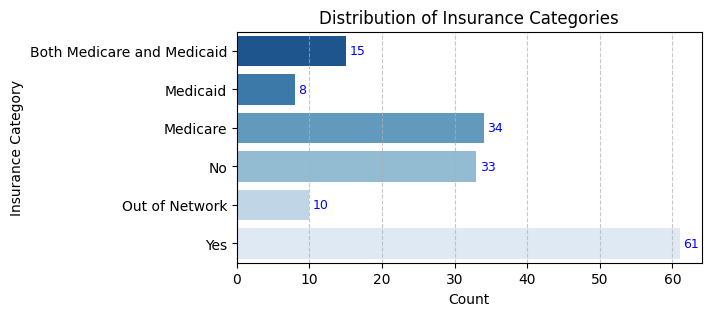

In [10]:

insurance_counts = Dementia['Insurance_Category'].value_counts().reset_index()
insurance_counts.columns = ['Insurance Category', 'Count']
insurance_counts = insurance_counts.sort_values(by='Insurance Category')

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=insurance_counts, y='Insurance Category', x='Count', palette='Blues_r')

for p in ax.patches:
        ax.annotate(
            format(p.get_width(), '.0f'),
            (p.get_x() + p.get_width() + 0.5, p.get_y() + p.get_height() / 2.),
            ha='left', va='center', fontsize=9, color='blue'
        )

plt.title("Distribution of Insurance Categories")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [12]:
Dementia.to_csv('Dementia.csv')